In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tec_reduced_model.set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
from tec_reduced_model.process_experimental_data import import_thermal_data, get_idxs
from __future__ import print_function
import dfols
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})

In [2]:
# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2
cells_ignore = ["789","790","791"]    # cells to ignore, in this case we ignore cell 791 because the data for that cell is faulty

In [3]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

In [4]:
def R_squared(solution, x_data, y_data):
    y_bar = np.mean(y_data)
    SS_tot = np.sum((y_data - y_bar) ** 2)
    res = y_data - solution(x_data)
    res = res[~np.isnan(res)]  # remove NaNs due to extrapolation
    SS_res = np.sum(res ** 2)
    n=len(y_data)

    return 1 - SS_res / n

In [5]:
def j0_neg(c_e, c_s_surf, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py

    Similar could be done for the positive exchange current density
    """

    # m_ref = 6.48e-7  # (A/m2)(mol/m3)**1.5 - includes ref concentrations

    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 35000
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    c_n_max = pybamm.Parameter("Maximum concentration in negative electrode [mol.m-3]")

    return (
        m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_n_max - c_s_surf) ** 0.5
    )

In [6]:
# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)
    
    # Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

In [7]:

param.update({
    "Negative electrode exchange-current density [A.m-2]": j0_neg,
    "Negative electrode reaction coefficient": "[input]",
    "Negative electrode diffusivity [m2.s-1]" : "[input]",
}, check_already_exists=False)
    
    # Solve the model
simulation = pybamm.Simulation(
        model,
        parameter_values=param,
        experiment=experiment,
    )
    
def fitness(x):
    
    
    simulation.solve(inputs={"Negative electrode reaction coefficient": x[0,1],"Negative electrode diffusivity [m2.s-1]" : x[0,0]})
    solution = simulation.solution
    R_squared(solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"])

    
    return np.array(1-R_squared(solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]))     #(np.abs(sol_sq-exp_sq))

In [8]:
# Create bounds
max_bound = np.array([ 2.06e-12, 2.18589831e-6])
min_bound = np.array([ 2.06e-15, 2.18589831e-8])
bounds = (min_bound, max_bound)
#x0 =np.array([5e-14,6.48e-7])

In [9]:
%%time
# Set-up hyperparameters
options = {'c1': 0.8, 'c2': 0.7, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fitness, iters=1000)

2022-02-25 16:01:07,787 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.8, 'c2': 0.7, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |101/1000, best_cost=0.003542022-02-25 16:02:32,800 - pybamm.logger - WARNING - Calling variable outside interpolation range (returns 'nan')
2022-02-25 16:02:32,815 - pybamm.logger - WARNING - Calling variable outside interpolation range (returns 'nan')
pyswarms.single.global_best:  57%|█████▊    |575/1000, best_cost=0.003412022-02-25 16:09:00,364 - pybamm.logger - WARNING - Calling variable outside interpolation range (returns 'nan')
2022-02-25 16:09:00,364 - pybamm.logger - WARNING - Calling variable outside interpolation range (returns 'nan')
pyswarms.single.global_best:  95%|█████████▍|948/1000, best_cost=0.002182022-02-25 16:14:05,030 - pybamm.logger - WARNING - Calling variable outside interpolation range (returns 'nan')
2022-02-25 16:14:05,046 - pybamm.logger - WARNING - Calling variable outside interpolation ran

CPU times: total: 13min 39s
Wall time: 13min 39s


In [10]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)
param["Negative electrode diffusivity [m2.s-1]"] = pos[0]
param.update({
        "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": "[input]",
    }, check_already_exists=False)

# Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

# Solve the model
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)
simulation.solve( inputs={"Negative electrode reaction coefficient": pos[1]})
solution = simulation.solution


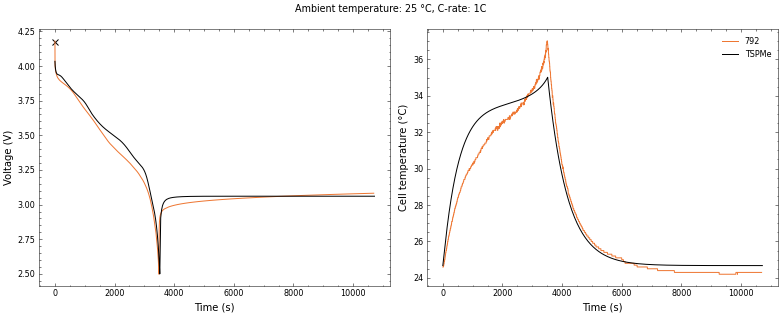

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    axes[0].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Voltage [V]"][idx_start[0] : idx_end[1]],
        label=cell,
    )
    axes[1].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        label=cell,
    )

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

    
axes[0].plot(
    solution["Time [s]"].entries,
    solution["Terminal voltage [V]"].entries,
    color="black",
    label="TSPMe",
)

axes[0].scatter(
    0,
    solution["X-averaged battery open circuit voltage [V]"].entries[0],
    marker="x",
    color="black",
)

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Voltage (V)")

axes[1].plot(
    solution["Time [s]"].entries,
    solution["X-averaged cell temperature [K]"].entries - 273.15,
    color="black",
    label="TSPMe",
)

axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Cell temperature (°C)")
axes[1].legend()
    
fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))    

fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [ ]:
# python implementation of particle swarm optimization (PSO)
# minimizing rastrigin and sphere function

import random
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys	 # max float


#-------fitness functions---------


#-------------------------

#particle class
class Particle:
    def __init__(self, fitness, dim, minx, maxx, seed):
        self.rnd = random.Random(seed)

        # initialize position of the particle with 0.0 value
        self.position = [0.0 for i in range(dim)]

        # initialize velocity of the particle with 0.0 value
        self.velocity = [0.0 for i in range(dim)]

        # initialize best particle position of the particle with 0.0 value
        self.best_part_pos = [0.0 for i in range(dim)]

        # loop dim times to calculate random position and velocity
        # range of position and velocity is [minx, max]
        for i in range(dim):
            self.position[i] = ((maxx - minx) *self.rnd.random() + minx)
            self.velocity[i] = ((maxx - minx) *self.rnd.random() + minx)

        # compute fitness of particle
        self.fitness = fitness(self.position) # curr fitness

        # initialize best position and fitness of this particle
        self.best_part_pos = copy.copy(self.position)
        self.best_part_fitnessVal = self.fitness # best fitness

        # particle swarm optimization function
def pso(fitness, max_iter, n, dim, minx, maxx):
    # hyper parameters
    w = 0.729 # inertia
    c1 = 1.49445 # cognitive (particle)
    c2 = 1.49445 # social (swarm)

    rnd = random.Random(0)

    # create n random particles
    swarm = [Particle(fitness, dim, minx, maxx, i) for i in range(n)]

    # compute the value of best_position and best_fitness in swarm
    best_swarm_pos = [0.0 for i in range(dim)]
    best_swarm_fitnessVal = sys.float_info.max # swarm best

    # computer best particle of swarm and it's fitness
    for i in range(n): # check each particle
        if swarm[i].fitness < best_swarm_fitnessVal:
            best_swarm_fitnessVal = swarm[i].fitness
            best_swarm_pos = copy.copy(swarm[i].position)

    # main loop of pso
    Iter = 0
    while Iter < max_iter:
	
        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter % 10 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = %.3f" % best_swarm_fitnessVal)

        for i in range(n): # process each particle
	
        # compute new velocity of curr particle
            for k in range(dim):
                r1 = rnd.random() # randomizations
                r2 = rnd.random()
	
                swarm[i].velocity[k] = (
                                    (w * swarm[i].velocity[k]) +
                                    (c1 * r1 * (swarm[i].best_part_pos[k] - swarm[i].position[k])) +
                                    (c2 * r2 * (best_swarm_pos[k] -swarm[i].position[k]))
                                )


		# if velocity[k] is not in [minx, max]
		# then clip it
                if swarm[i].velocity[k] < minx:
                    swarm[i].velocity[k] = minx
                elif swarm[i].velocity[k] > maxx:
                    swarm[i].velocity[k] = maxx


        # compute new position using new velocity
        for k in range(dim):
            swarm[i].position[k] += swarm[i].velocity[k]

        # compute fitness of new position
        swarm[i].fitness = fitness(swarm[i].position)

        # is new position a new best for the particle?
        if swarm[i].fitness < swarm[i].best_part_fitnessVal:
            swarm[i].best_part_fitnessVal = swarm[i].fitness
            swarm[i].best_part_pos = copy.copy(swarm[i].position)

        # is new position a new best overall?
        if swarm[i].fitness < best_swarm_fitnessVal:
            best_swarm_fitnessVal = swarm[i].fitness
            best_swarm_pos = copy.copy(swarm[i].position)
	
        # for-each particle
        Iter += 1
#end_while
    return best_swarm_pos
# end pso


#----------------------------
# Driver code for rastrigin function

print("\nBegin particle swarm optimization on rastrigin function\n")
dim = 3
fitness = fitness


print("Goal is to minimize Rastrigin's function in " + str(dim) + " variables")
print("Function has known min = 0.0 at (", end="")
for i in range(dim-1):
    print("0, ", end="")
print("0)")

num_particles = 50
max_iter = 100

print("Setting num_particles = " + str(num_particles))
print("Setting max_iter = " + str(max_iter))
print("\nStarting PSO algorithm\n")



best_position = pso(fitness, max_iter, num_particles, dim, -10.0, 10.0)

print("\nPSO completed\n")
print("\nBest solution found:")
print(["%.6f"%best_position[k] for k in range(dim)])
fitnessVal = fitness(best_position)
print("fitness of best solution = %.6f" % fitnessVal)

print("\nEnd particle swarm for rastrigin function\n")


print()
print()


# Driver code for Sphere function
print("\nBegin particle swarm optimization on sphere function\n")
dim = 3
fitness = fitness_sphere


print("Goal is to minimize sphere function in " + str(dim) + " variables")
print("Function has known min = 0.0 at (", end="")
for i in range(dim-1):
    print("0, ", end="")
print("0)")

num_particles = 50
max_iter = 100

print("Setting num_particles = " + str(num_particles))
print("Setting max_iter = " + str(max_iter))
print("\nStarting PSO algorithm\n")



best_position = pso(fitness, max_iter, num_particles, dim, -10.0, 10.0)

print("\nPSO completed\n")
print("\nBest solution found:")
print(["%.6f"%best_position[k] for k in range(dim)])
fitnessVal = fitness(best_position)
print("fitness of best solution = %.6f" % fitnessVal)

print("\nEnd particle swarm for sphere function\n")
